## Setup

In [1]:
# Setup
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import random
import collections
import pandas as pd
import seaborn as sns
import pairs_trading as pt
np.random.seed(42)
pd.set_option('display.max_columns', None)
%matplotlib inline

## Functions

In [2]:
def comp_strat(high, low, A, B, C, D, alpha, T, initial_kalman, initial_pred = "default"):
    ''' Returns, for a pair of securities over a given chunk,
            - sequence of estimated hidden spreads x_k
            - sequence of uncertainty around hidden spreads R_k
            - strategies chosen strat
            - the final values from the kalman filter final_kalman to be passed on
            - the final predictions for spread and unc. final_pred to be passed on
        given 
            - the price sequences high, low
            - the estimated parameters A, B, C, D
            - the uncertainty treshold alpha (free parameter)
            - holding period for each trade T (free parameter)
            - initial values for the kalman filter initial_kalman
            - initial predictions predictions for spread and unc. initial_pred
        using the Kalman Filter.
    '''
    
    y = high - low
    start = 1 + T
    
    # compute best estimate of hidden spread
    x, R, sigma, K = pt.kalman_filter(y, A = A, B = B, C = C, D = D, initial =  initial_kalman)
    x = np.asarray(x)
    R = np.asarray(R)
    
    # initialise conditional expectation on past observation
    x_k = np.zeros(len(x))
    R_k = np.zeros(len(x))
    strat = np.zeros(len(x))
    
    # compute strategy for initial period
    if initial_pred != "default": 
        x_k[0] = initial_pred[0]
        R_k[0] =  initial_pred[1]
        if (y[0] - x_k[0]) / np.sqrt(R_k[0]) > alpha:
            strat[0] = 1
        elif (y[0] - x_k[0]) / np.sqrt(R_k[0]) < - alpha:
            strat[0] = -1
        else:
            strat[0] = 0
        
    # compute strategy for each period where 1 = short "high" and
    # long "low", -1 vice versa, and 0 = do not trade  
    for i in range(1, len(x)):
        x_k[i] = A + B * x[i - 1]
        R_k[i] = (B ** 2) * R[i - 1] + C ** 2
        if (y[i] - x_k[i]) / np.sqrt(R_k[i]) > alpha:
            strat[i] = 1
        elif (y[i] - x_k[i]) / np.sqrt(R_k[i]) < - alpha:
            strat[i] = -1
        else:
            strat[i] = 0
            
    # compute ratio of low stock to high stock 
    r = low / high
        
    # compute final kalman
    final_kalman = (x[-1], R[-1])
    
    # compute x_N+1 | N and R_N+1 | N to pass on to next chunk
    x_N_plus_1 = A + B * x[-1] 
    R_N_plus_1 = B ** 2 * R[-1] + C ** 2
    final_pred = (x_N_plus_1, R_N_plus_1)
    
    return x_k, R_k, strat, final_kalman, final_pred

In [3]:
def pairs_trading(high, low, alpha, 
                  T, k_init = 100, 
                  k = 30, p = "all", 
                  max_iterations = 1000, 
                  threshold = 10e-10, 
                  initial_eta = (1.2, 0.5, 0.3, 0.7),
                  initial_kalman = (0, 0.1)):
    ''' Returns, for a pair of securities,
            - the profit following the strategies profit
            - the cumulative profit following the strategies cum_profit
            - sequence of estimated hidden spreads x
            - sequence of uncertainty around hidden spreads R
            - strategies chosen strat 
            - sequence of observed spreads y
        evaluated on all chunks but the first, given 
            - the price sequences high, low
            - the uncertainty treshold alpha (free parameter)
            - holding period for each trade T (free parameter)
            - the size of the first training chunk k_init
            - the size of the following chunks k 
            - the number of previous chunks to be considered 
              when computing the strategy p (takes integer values or "all")
            - max_iterations for the EM convergence 
            - threshold for EM conergence
            - initial parameters initial_eta 
            - intial values for the kalman filter intial_kalman
        using the Kalman Filter and the EM-smoothing-algorithm. 
    '''
    # scale 
    high = 100 * high / low[0] 
    low = 100 * low / low[0]
    
    y = high - low
    n = len(y)

    # split data into chunks 
    high_chunks = np.array_split(high[k_init:], int((n - k_init) / k))
    low_chunks = np.array_split(low[k_init:], int((n - k_init) / k))
    y_chunks = np.array_split(y[k_init:], int((n - k_init) / k))
    
    high_chunks.insert(0, high[:k_init])
    low_chunks.insert(0, low[:k_init])
    y_chunks.insert(0, y[:k_init])
    
    # run EM-algorithm on initial chunk
    A, B, C, D, eta, x_N = pt.EM(y_chunks[0],
                                 max_iterations = max_iterations, 
                                 threshold = threshold,
                                 initial_eta = initial_eta,
                                 initial_kalman = initial_kalman)
    
    # check that B is leq 1
    if B > 1:
        raise('ERROR: B>1')
        
    # compute strategy on the second chunk and initialise output 
    x, R, strat, final_kalman, final_pred = comp_strat(high = high_chunks[1],
                                             low = low_chunks[1],
                                             A = A,
                                             B = B,
                                             C = C,
                                             D = D,
                                             alpha = alpha,
                                             T = T, 
                                             initial_kalman = "default", 
                                             initial_pred = "default")
    
    # reestimate parameters and compute profit chunkwise         
    for i in range(1, int((n - k_init) / k)):
        if p == "all": 
            A, B, C, D, eta, x_N = pt.EM(y[:(k_init + i * k)],
                                         max_iterations = max_iterations, 
                                         threshold = threshold,
                                         initial_eta = (A, B, C, D),
                                         initial_kalman = initial_kalman)
        else: 
            if i - p < 0: 
                beg = 0 
            else: 
                beg =  i - p + 1  
                
            A, B, C, D, eta, x_N = pt.EM(np.concatenate(y_chunks[beg:(i + 1)]), 
                                         max_iterations = max_iterations,
                                         threshold = threshold,
                                         initial_eta = (A, B, C, D),
                                         initial_kalman = initial_kalman)
        if B > 1:
            raise('ERROR: B>1')
            
        res = comp_strat(high = high_chunks[i + 1],
                         low = low_chunks[i + 1],
                         A = A,
                         B = B,
                         C = C,
                         D = D,
                         alpha = alpha,
                         T = T, 
                         initial_kalman = final_kalman, 
                         initial_pred = final_pred) 
        
        x = np.hstack((x, res[0]))
        R = np.hstack((R, res[1]))
        strat = np.hstack((strat, res[2]))
        final_kalman = res[3]
        final_pred = res[4]
    
    x = np.hstack((np.zeros(k_init), x))
    R = np.hstack((np.zeros(k_init), R))
    strat = np.hstack((np.zeros(k_init), strat))
    
    # ratio of low stock to high stock
    r = low/high
    
    # compute profit 
    profit = np.zeros(n)
    
    for i in range(T, n): 
        profit[i] = strat[i - T] * (r[i - T]  * (high[i - T]  -  high[i])  
                                    +  low[i] - low[i - T])
        
    cum_profit = np.cumsum(profit)

    return profit, cum_profit, x, R, strat, y

## Load data

In [4]:
# set wd
wd = !pwd
wd = wd[0]

In [5]:
# simulate GAUSS1-GAUSS2
def trajectory(x_0, n, sigma):
    x = np.zeros(n)
    x[0] = x_0 
    for i in range(1, n): 
        x[i] = x[i - 1] * np.exp(sigma * np.sqrt(1 / n ) * np.random.normal())
    return(x)
n = 252
GAUSS1 = trajectory(1000, n, 0.2)
GAUSS2 = GAUSS1 - 300 + np.random.normal(scale = 10, size = n)

In [6]:
# load data VOT-MDYG
MDYG = pd.read_csv('yearlydata/IEX_stock_MDYG_chart_1y.csv')
MDYG = np.asarray(MDYG['close'],dtype=np.float32)
VOT = pd.read_csv('yearlydata/IEX_stock_VOT_chart_1y.csv')
VOT = np.asarray(VOT['close'],dtype=np.float32)

In [7]:
# load data VLO-CVX
VLO = pd.read_csv('yearlydata/IEX_stock_VLO_chart_1y.csv')
VLO = np.asarray(VLO['close'],dtype=np.float32)
CVX = pd.read_csv('yearlydata/IEX_stock_CVX_chart_1y.csv')
CVX = np.asarray(CVX['close'],dtype=np.float32)

In [8]:
# load data BHP-BBL
BBL = pd.read_csv('yearlydata/IEX_stock_BBL_chart_1y.csv')
BBL = np.asarray(BBL['close'],dtype=np.float32)
BHP = pd.read_csv('yearlydata/IEX_stock_BHP_chart_1y.csv')
BHP = np.asarray(BHP['close'],dtype=np.float32)

## Plots

In [9]:
# define plot 1
def plot1(sec, alpha, T, k_init, k, filename = "plot1.png"): #
    m = len(alpha) * len(T)
    n = int(np.ceil(m / 2))
    fig, axes = plt.subplots(n, 2, sharex = False, figsize = (15, n * 4))
    i = 0 
    j = 0
    for a in alpha: 
        for t in T: 
            df = pd.DataFrame()
            for key, value in sec.items(): 
                df[key] = pairs_trading(value[0], value[1], a, t, k_init, k)[1]
            df.iloc[k_init:,:].plot(ax = axes[i, j], title = "alpha = " + str(a) + ", T = " + str (t))
            if j == 1: 
                i += 1
                j = 0
            else: 
                j = 1
    plt.tight_layout()
    plt.savefig("figs/" + filename, dpi = 150)
    return

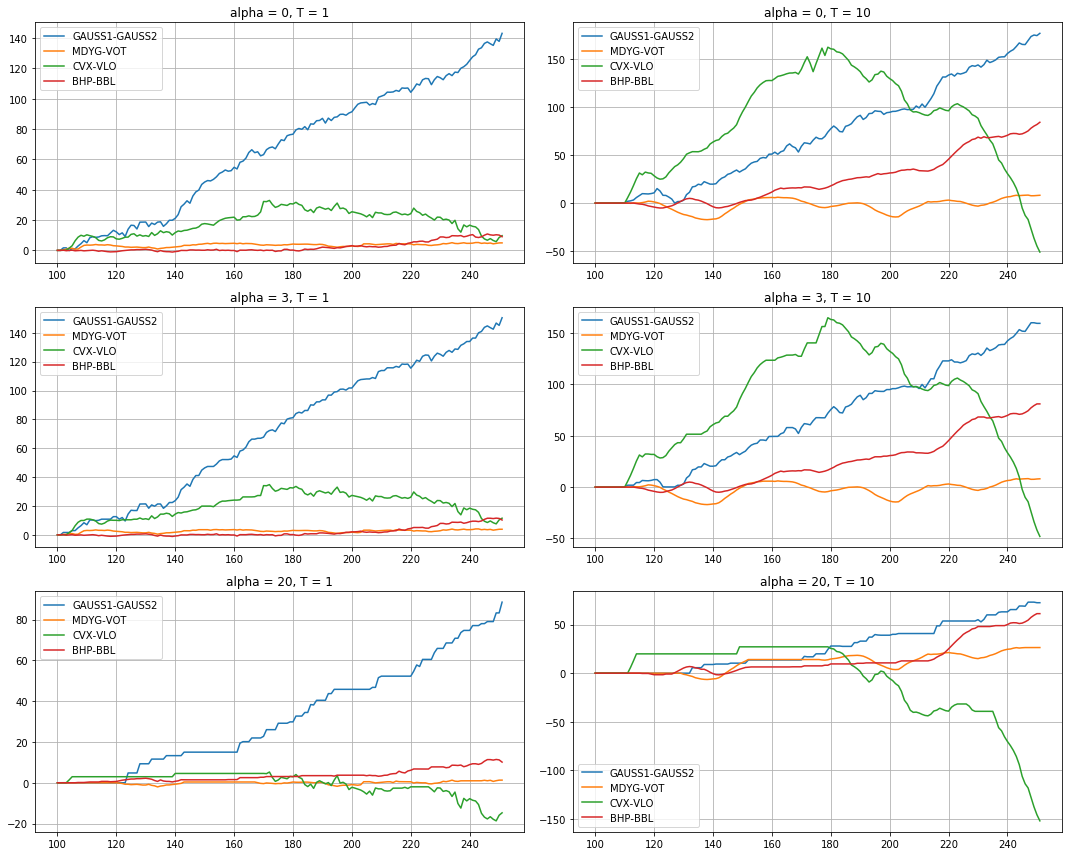

In [10]:
# plot plot 1
securities = {"GAUSS1-GAUSS2": [GAUSS1, GAUSS2], "MDYG-VOT": [MDYG, VOT], 
             "CVX-VLO": [CVX, VLO], "BHP-BBL":[BHP, BBL]}
alpha = [0, 3, 20]
T = [1, 10]
k_init = 100 
k = 50
plot1(securities, alpha, T, k_init, k)

In [11]:
# define plot 2
def plot2(sec, alpha, T, k_init, k, filename = "plot2.png"): #
    m = len(alpha) * len(T)
    n = int(np.ceil(m / 2))
    fig, axes = plt.subplots(n, 2, sharex = False, figsize = (15, n * 4))
    i = 0 
    j = 0
    for a in alpha: 
        for t in T: 
            df = pd.DataFrame()
            for key, value in sec.items(): 
                res = pairs_trading(value[0], value[1], a, t, k_init, k)
                df[key] = (res[5] - res[2]) / np.sqrt(res[3])
            df.plot(ax = axes[i, j], title = "alpha = " + str(a) + ", T = " + str (t))
            axes[i, j].axhline(y = a, label = "alpha", c = "dimgrey", linestyle = "--")
            axes[i, j].axhline(y = - a, c = "dimgrey", linestyle = "--")
            axes[i, j].legend()
            if j == 1: 
                i += 1
                j = 0
            else: 
                j = 1
    plt.tight_layout()
    plt.savefig("figs/" + filename, dpi = 150)
    return

/Users/richardknudsen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide


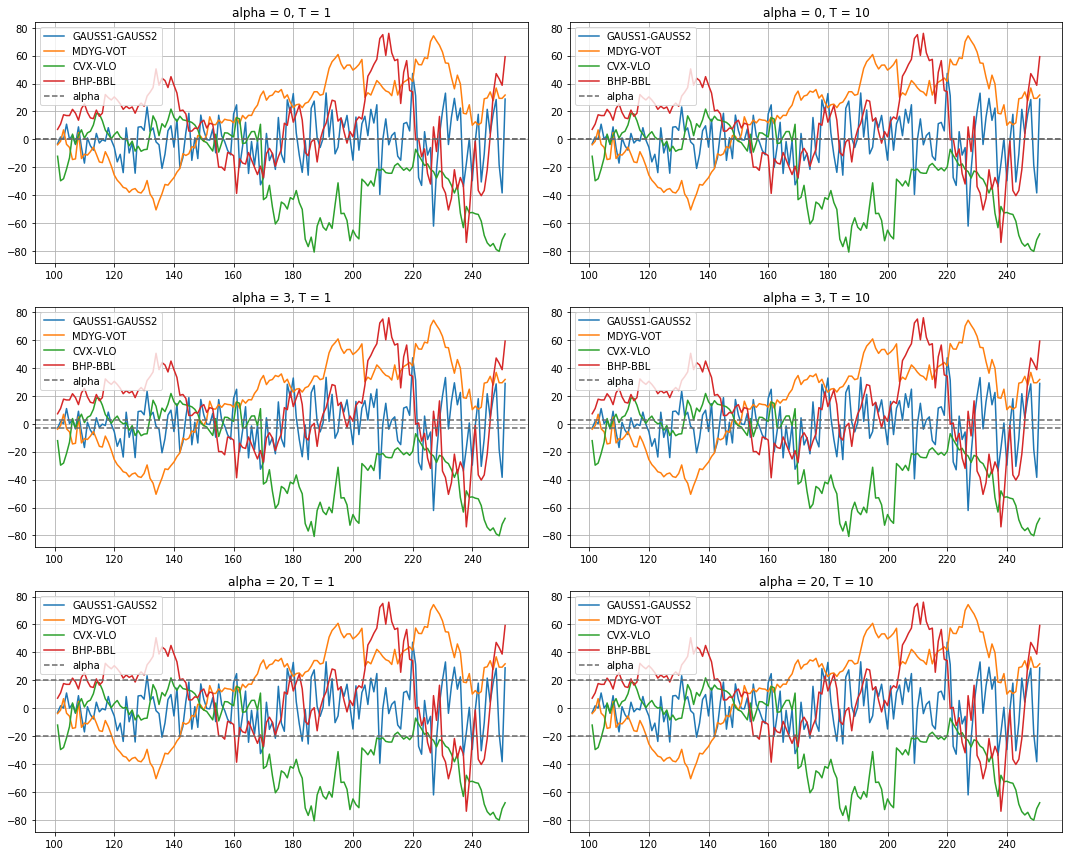

In [12]:
# plot plot 2
securities = {"GAUSS1-GAUSS2": [GAUSS1, GAUSS2], "MDYG-VOT": [MDYG, VOT], 
             "CVX-VLO": [CVX, VLO], "BHP-BBL":[BHP, BBL]}
alpha = [0, 3, 20]
T = [1, 10]
k_init = 100
k = 50
plot2(securities, alpha, T, k_init, k)

In [13]:
# define plot 3
def plot3(sec, alpha, T, k_init, k, filename = "plot3.png"): #
    m = len(alpha) * len(T)
    n = int(np.ceil(m / 2))
    fig, axes = plt.subplots(n, 2, sharex = False, figsize = (10, n * 4))
    i = 0 
    j = 0
    for a in alpha: 
        for t in T: 
            for key, value in sec.items(): 
                s = pairs_trading(value[0], value[1], a, t, k_init, k)[4]
                s[:k_init] = np.nan
                s = s.reshape(12, 21) 
                title = key + ": " + "alpha = " + str(a) + ", T = " + str (t)
                sns.heatmap(s, cmap = "YlGnBu", cbar = False, 
                            ax = axes[i, j]).set_title(title)
                axes[i, j].set_ylabel('month')
                axes[i, j].set_xlabel('day')
                axes[i, j].set_yticklabels(list(range(1, 13)))
                axes[i, j].set_xticklabels(list(range(1, 22)))
            if j == 1: 
                i += 1
                j = 0
            else: 
                j = 1
    plt.tight_layout()
    plt.savefig("figs/" + filename, dpi = 150)
    return

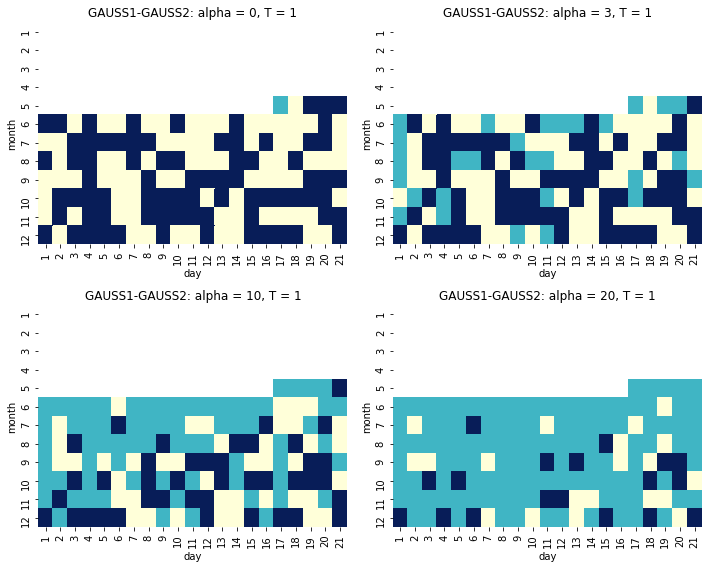

In [14]:
# plot plot 3
securities = {"GAUSS1-GAUSS2": [GAUSS1, GAUSS2]}
alpha = [0, 3, 10, 20]
T = [1]
k_init = 100
k = 50
plot3(securities, alpha, T, k_init, k)

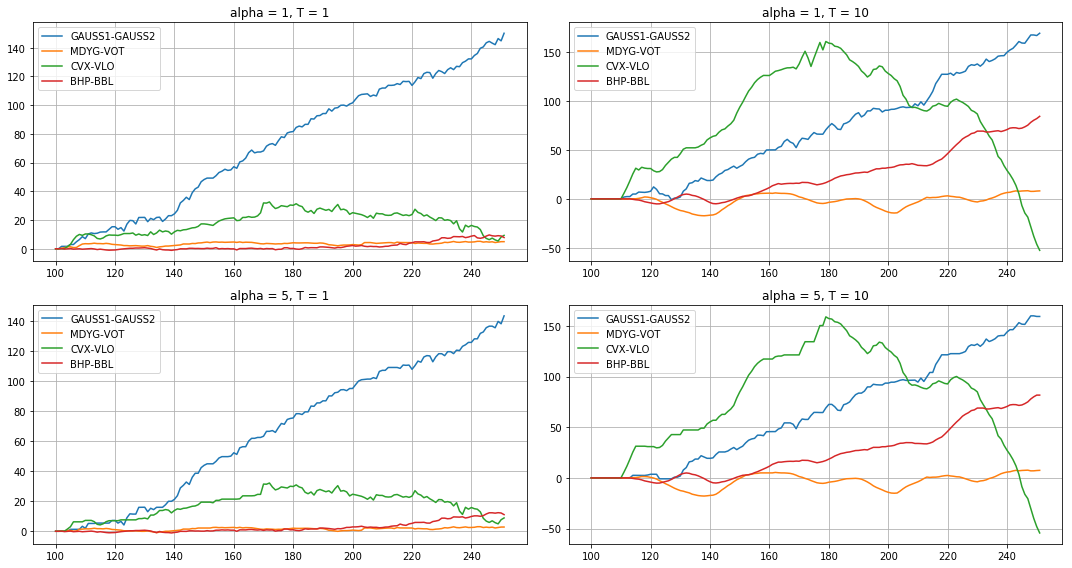

In [15]:
# plot 4 for presentation 
securities = {"GAUSS1-GAUSS2": [GAUSS1, GAUSS2], "MDYG-VOT": [MDYG, VOT], 
             "CVX-VLO": [CVX, VLO], "BHP-BBL":[BHP, BBL]}
alpha = [1, 5]
T = [1, 10]
k_init = 100 
k = 50
plot1(securities, alpha, T, k_init, k, filename= "plot4.png")

/Users/richardknudsen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide


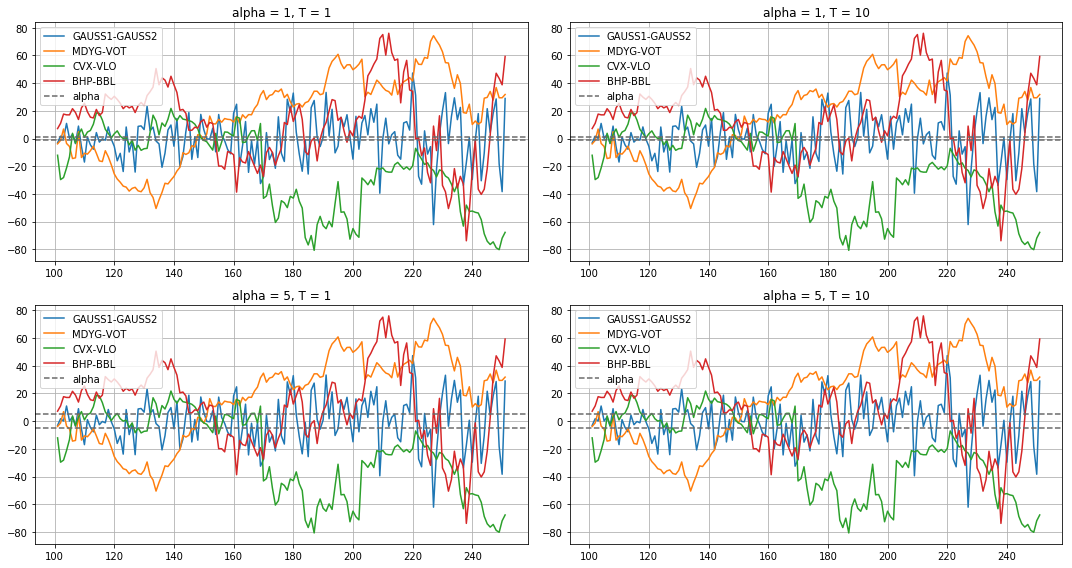

In [16]:
# plot 5 for prsentation 
securities = {"GAUSS1-GAUSS2": [GAUSS1, GAUSS2], "MDYG-VOT": [MDYG, VOT], 
             "CVX-VLO": [CVX, VLO], "BHP-BBL":[BHP, BBL]}
alpha = [1, 5]
T = [1, 10]
k_init = 100
k = 50
plot2(securities, alpha, T, k_init, k, filename = "plot5.png")